<a href="https://colab.research.google.com/github/jonathancagua/IA-PINN/blob/main/TP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

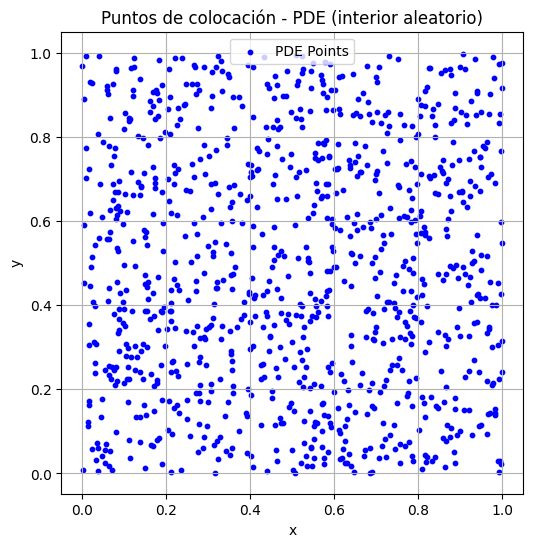

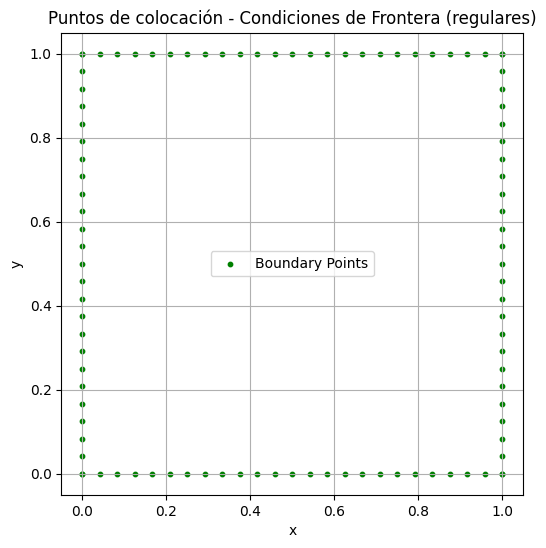

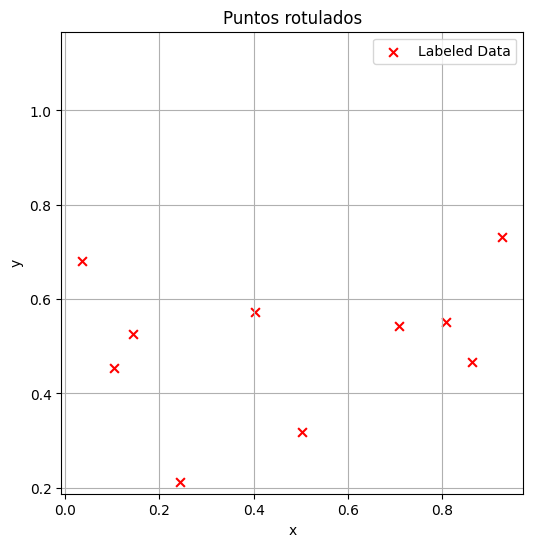


Valores interpolados en puntos rotulados:
     x      y          p          u          v
 0.104  0.453     0.0036    -0.0201    -0.0267
 0.403  0.573    -0.0914     0.1341     0.0440
 0.808  0.551    -0.0368    -0.0544     0.2232
 0.501  0.318    -0.0144     1.0000     0.0000
 0.243  0.213    -0.0180    -0.2260    -0.1680
 0.144  0.527     0.0039    -0.0806    -0.0774
 0.707  0.543    -0.0002    -0.0554    -0.1244
 0.927  0.731    -0.0519     0.0088     0.1868
 0.863  0.466    -0.0656    -0.0205     0.1848
 0.036  0.681    -0.0011    -0.0269     0.0053


In [1]:
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/pressure.mat
!wget -q https://github.com/jonathancagua/IA-PINN/raw/main/velocity.mat

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Cargar datos
data_pressure = loadmat('pressure.mat')
data_velocity = loadmat('velocity.mat')

p = data_pressure['p']
u = data_velocity['u']
v = data_velocity['v']

# Extraer valores de la malla
ny, nx = p.shape
x_vals = np.linspace(0, 1, nx)
y_vals = np.linspace(0, 1, ny)

# Cantidades de puntos
Npde = 1000
Nbc = 100
Ndata = 10

# --- PUNTO 1: puntos de colocación PDE (interior aleatorio) ---
x_pde = np.random.uniform(0.0, 1.0, Npde)
y_pde = np.random.uniform(0.0, 1.0, Npde)

plt.figure(figsize=(6, 6))
plt.scatter(x_pde, y_pde, s=10, c='blue', label='PDE Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos de colocación - PDE (interior aleatorio)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

# --- PUNTO 2: puntos de frontera BC (regulares) ---
Nbc_per_edge = Nbc // 4

x_bc_top = np.linspace(0, 1, Nbc_per_edge)
y_bc_top = np.ones_like(x_bc_top)

x_bc_bottom = np.linspace(0, 1, Nbc_per_edge)
y_bc_bottom = np.zeros_like(x_bc_bottom)

y_bc_left = np.linspace(0, 1, Nbc_per_edge)
x_bc_left = np.zeros_like(y_bc_left)

y_bc_right = np.linspace(0, 1, Nbc_per_edge)
x_bc_right = np.ones_like(y_bc_right)

x_bc = np.concatenate([x_bc_top, x_bc_bottom, x_bc_left, x_bc_right])
y_bc = np.concatenate([y_bc_top, y_bc_bottom, y_bc_left, y_bc_right])

plt.figure(figsize=(6, 6))
plt.scatter(x_bc, y_bc, s=10, c='green', label='Boundary Points')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos de colocación - Condiciones de Frontera (regulares)')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

# --- PUNTO 3: puntos rotulados y valores interpolados ---

# Puntos rotulados (aleatorios en el dominio)
x_data = np.random.uniform(0, 1, Ndata)
y_data = np.random.uniform(0, 1, Ndata)

# Interpolador robusto
def interpolate_field(field, x_vals, y_vals, x, y):
    x_idx = np.clip(np.searchsorted(x_vals, x) - 1, 0, len(x_vals) - 2)
    y_idx = np.clip(np.searchsorted(y_vals, y) - 1, 0, len(y_vals) - 2)

    x0, x1 = x_vals[x_idx], x_vals[x_idx + 1]
    y0, y1 = y_vals[y_idx], y_vals[y_idx + 1]

    dx = x1 - x0
    dy = y1 - y0
    if dx == 0 or dy == 0:
        return field[y_idx, x_idx]

    fx00 = field[y_idx, x_idx]
    fx10 = field[y_idx, x_idx + 1]
    fx01 = field[y_idx + 1, x_idx]
    fx11 = field[y_idx + 1, x_idx + 1]

    return (
        fx00 * (x1 - x) * (y1 - y) +
        fx10 * (x - x0) * (y1 - y) +
        fx01 * (x1 - x) * (y - y0) +
        fx11 * (x - x0) * (y - y0)
    ) / (dx * dy)

# Interpolar datos rotulados
p_data = np.array([interpolate_field(p, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
u_data = np.array([interpolate_field(u, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])
v_data = np.array([interpolate_field(v, x_vals, y_vals, x, y) for x, y in zip(x_data, y_data)])

# Mostrar figura con puntos rotulados
plt.figure(figsize=(6, 6))
plt.scatter(x_data, y_data, s=40, c='red', marker='x', label='Labeled Data')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Puntos rotulados')
plt.grid(True)
plt.axis('square')
plt.legend()
plt.show()

# Mostrar tabla con valores interpolados
print("\nValores interpolados en puntos rotulados:")
print(f"{'x':>6} {'y':>6} {'p':>10} {'u':>10} {'v':>10}")
for x, y, p_val, u_val, v_val in zip(x_data, y_data, p_data, u_data, v_data):
    print(f"{x:6.3f} {y:6.3f} {p_val:10.4f} {u_val:10.4f} {v_val:10.4f}")



Los puntos para la PDE no deben incluirse en las fronteras del dominio, ya que las ecuaciones diferenciales se evalúan solo en el interior, mientras que las condiciones de frontera se tratan por separado. Incluir puntos en el borde mezclaría dos tipos de información que deben manejarse con funciones de pérdida distintas.